In [219]:
# Written by Sebastian Matiz

import matplotlib.pyplot as plt
import numpy as np
import math

In [220]:
# betting strategy
BASIC_STRATEGY = 'BASIC_STRATEGY'
CARD_COUNTING = 'CARD_COUNTING'
WONGING = 'WONGING'

# staking strategy
KELLY_CRITERION = 'KELLY_CRITERION'
OSCARS_GRIND = 'OSCARS_GRIND'
MARTINGALE_SYSTEM = 'MARTINGALE_SYSTEM'
PAROLI_SYSTEM = 'PAROLI_SYSTEM'

# actions
HIT = 'HIT'
STAND = 'STAND'
SPLIT = 'SPLIT'
DOUBLE_DOWN = 'DOUBLE_DOWN'
BUST = 'BUST'
START = 'START'

# actions cont.
YES = 'YES'
NO = 'NO'
RAND = 'RAND'

In [221]:
# Deck of cards class

def get_suit(underlying_card_value):
    return math.ceil(underlying_card_value / 13)

def get_card_black_jack_value(underlying_card_value):
    card_true_value = underlying_card_value % 13
    if (card_true_value == 1):
        return 11
    elif (card_true_value >= 11 or card_true_value == 0):
        return 10
    else:
        return card_true_value
    
class Deck:
    def __init__(self, shuffle = True):
        # suit 1 = clubs
        # suit 2 = spades
        # suit 3 = hearts
        # suit 4 = diamond
        self.cards = np.arange(1, 53)
        if (shuffle):
            np.random.shuffle(self.cards)
        self.removed = np.empty(0)
        
    def reshuffle_deck(self):
        self.cards = np.arange(1, 53)
        np.random.shuffle(self.cards)
        self.removed = np.empty(0)
        
    def pop(self):
        popped_card = self.cards[0]
        self.cards = np.delete(self.cards, 0)
        np.append(self.removed, popped_card)
        return get_card_black_jack_value(popped_card)
    
    def get_num_cards(self):
        return len(self.cards)

In [222]:
# Decks of cards class

class Decks:
    def __init__(self, number_of_decks = 1, shuffle = True, reshuffle_rate = .5):
        self.number_of_decks = number_of_decks
        self.decks = np.array([ Deck() for i in range(number_of_decks) ])
        self.reshuffle_rate = reshuffle_rate
            
    def reshuffle_decks(self):
        self.decks = np.array([ Deck() for i in range(self.number_of_decks) ])
        
    def pop(self):
        if (self.get_num_cards() / (self.number_of_decks * 52) < self.reshuffle_rate):
            self.reshuffle_decks()
        if (len(self.decks) == 0):
            self.reshuffle_decks()
            return self.pop()
        if (len(self.decks[0].cards) > 0):
            return self.decks[0].pop()
        else:
            self.decks = np.delete(self.decks, 0)
            return self.pop()
    
    def get_num_cards(self):
        num = 0
        for deck in self.decks:
            num += deck.get_num_cards()
        return num

In [223]:
# runners
def run(decks, bankroll, staking_strat, betting_strat, number_of_players, insurance, rounds): 
    print('Not implemented yet!')
    
def run_basic_strategy(decks, number_of_rounds, number_of_players, bankroll, bet_size, black_jack_type):
    bj_extra_inverse_ratio = .5 if (black_jack_type == '3:2') else .2
    players = init_players(number_of_players, bankroll)  
    dealer_hand = { 'hand': [] } 
    historical_bankroll = []
    
    for i in range(number_of_players):
        historical_bankroll.append([bankroll])
    
    for i in range(number_of_rounds):
        execute_dealer_actions_for_round(decks, dealer_hand, players, bet_size)

        for player in players:
            execute_basic_strategy_for_round(decks, dealer_hand, player)

        dealer_hand = execute_dealer_actions(decks, dealer_hand)    
        compare_hands_to_dealer(dealer_hand, players, bj_extra_inverse_ratio)
        log_historical_bankroll(historical_bankroll, players)
        clear_hands(dealer_hand, players)
    return historical_bankroll

In [224]:
# misc
def log_historical_bankroll(historical_bankroll, players):
    for index, player in enumerate(players):
        historical_bankroll[index].append(player['curr_bankroll'])

In [225]:
# Dealer action functions

# player obj = {
#     index: 0,
#     starting_bankroll: $200,
#     curr_bankroll: $100,
#     curr_hands: [
#         {
#             hand: [10, 7],
#             bet: $10
#         }
#     ]
# }
    
def execute_dealer_actions_for_round(decks, dealer_hand, players, bet_size):
    place_init_player_bets(players, bet_size)
    
    # first card distribution
    distribute_card_to_each_player(decks, players)
    
    # dealer up card
    distribute_card_to_dealer(decks, dealer_hand)
    
    # second card distribution
    distribute_card_to_each_player(decks, players)
    
    # dealer down card
    distribute_card_to_dealer(decks, dealer_hand)
    
    
def distribute_card_to_dealer(decks, dealer_hand):
    dealer_hand['hand'] = add_card_to_hand(decks, dealer_hand)['hand']

        
def init_players(number_of_players, bankroll):
    players = []
    for i in range(number_of_players):
        player_obj = {
            'index': i,
            'start_bankroll': bankroll,
            'curr_bankroll': bankroll,
            'curr_hands': [{ 'hand': [], 'bet': 0 }]
        }
        players.append(player_obj)
    return players


def place_init_player_bets(player_objs, bet_size):
    for player_obj in player_objs:
        player_obj['curr_hands'][0]['bet'] = bet_size

def distribute_card_to_each_player(decks, player_objs):
    for player_obj in player_objs:
        for index, hand in enumerate(player_obj['curr_hands']):
            player_hand = add_card_to_hand(decks, hand)
            player_obj['curr_hands'][index] = player_hand
        
# play until 17 or bust
def execute_dealer_actions(decks, dealer_hand_obj):
    hand_action = START
    while hand_action != BUST and hand_action != STAND:
        hand_action = get_action_for_dealer(dealer_hand_obj)
        if (hand_action == HIT):
            dealer_hand_obj = add_card_to_hand(decks, dealer_hand_obj)
    return dealer_hand_obj
        
def get_action_for_dealer(dealer_hand_obj):
    dealer_hand = dealer_hand_obj['hand']
    dealer_hand_value = np.sum(dealer_hand)
    if (dealer_hand_value < 17):
        return HIT
    if (dealer_hand_value >= 17 and dealer_hand_value <= 21):
        return STAND
    if (dealer_hand_value > 21 and 11 in dealer_hand and dealer_hand_value - 10 <= 21 and dealer_hand_value - 10 >= 17):
        dealer_hand_obj['hand'] = np.where(dealer_hand_obj['hand'] == 11, 1, dealer_hand_obj['hand'])
        return STAND
    if (dealer_hand_value > 21 and 11 in dealer_hand and dealer_hand_value - 10 <= 21 and dealer_hand_value - 10 < 17):
        dealer_hand_obj['hand'] = np.where(dealer_hand_obj['hand'] == 11, 1, dealer_hand_obj['hand'])
        return HIT
    if (dealer_hand_value > 21):
        return BUST

def compare_hands_to_dealer(dealer_hand_obj, players, bj_extra_inverse_ratio):
    dealer_hand_value = np.sum(dealer_hand_obj['hand'])
    for player in players:
        for hand in player['curr_hands']:
            player_hand_value = np.sum(hand['hand'])
            win_extra = hand['bet'] * bj_extra_inverse_ratio

            # player and dealer don't bust
            if (player_hand_value >= dealer_hand_value and player_hand_value <= 21):
                if (player_hand_value > dealer_hand_value):
                    add_bet_from_bankroll(player, hand['bet'])
                elif (player_hand_value < dealer_hand_value):
                    subtract_bet_from_bankroll(player, hand['bet'])
                elif (player_hand_value == 21 and dealer_hand_value != 21):
                    add_bet_from_bankroll(player, win_extra)
            
            # dealer busts and player doesn't
            elif (dealer_hand_value > 21 and player_hand_value <= 21):
                add_bet_from_bankroll(player, hand['bet'])
                if (player_hand_value == 21):
                    add_bet_from_bankroll(player, win_extra)
            else:
                subtract_bet_from_bankroll(player, hand['bet'])

                
def clear_hands(dealer_hand, players):
    dealer_hand['hand'] = []
    for player in players:
        player['curr_hands'] = [{ 'hand': [], 'bet': 0 }]

In [226]:
# Player action functions 

# hand obj = {
#     hand: [10,7],
#     bet: $10
# }   

# TODO: Expand this to have hand action be determined by strategy, i.e make this generic
def execute_player_actions(decks, dealer_hand, player, player_hands, player_hand_obj, hand_index):
    hand_action = START
    while hand_action != STAND:
        hand_action = get_action_for_basic_strategy(dealer_hand['hand'][0], player_hand_obj)
        if (hand_action == HIT):
            player_hand_obj = add_card_to_hand(decks, player_hand_obj)
        if (hand_action == SPLIT):
            player_hand_obj = split_hand(decks, player, player_hands, player_hand_obj, hand_index)
        if (hand_action == DOUBLE_DOWN):
            player_hand_obj = double_down_on_hand(decks, player, player_hand_obj)
            hand_action = STAND
        player_hands[hand_index] = player_hand_obj
        
def add_card_to_hand(decks, player_hand_obj):
    next_card = decks.pop()
    updated_hand_values = np.append(player_hand_obj['hand'], next_card)
    player_hand_obj['hand'] = updated_hand_values
    return player_hand_obj

def split_hand(decks, player, player_hands, player_hand_obj, hand_index):
    player_hand_obj['hand'] = np.delete(player_hand_obj['hand'], 0)
    
    split_player_hand_obj = {
        'hand': player_hand_obj['hand'],
        'bet': player_hand_obj['bet']
    }
    
    player_hand_obj = add_card_to_hand(decks, player_hand_obj)
    split_player_hand_obj = add_card_to_hand(decks, split_player_hand_obj)
    
    player_hands[hand_index] = player_hand_obj
    player_hands.append(split_player_hand_obj)
    
    return player_hand_obj

def subtract_bet_from_bankroll(player, bet):
    player['curr_bankroll'] = player['curr_bankroll'] - bet

def add_bet_from_bankroll(player, bet):
    player['curr_bankroll'] = player['curr_bankroll'] + bet

def double_down_on_hand(decks, player, player_hand_obj):
    player_hand_obj['bet'] = player_hand_obj['bet'] * 2
    return add_card_to_hand(decks, player_hand_obj)

In [227]:
# Basic strategy involves making the statistically optimal decision for each possible hand based on the player's cards and the dealer's visible card. This strategy minimizes the house edge.
# Hard Hands (no Ace or Ace counted as 1):

# 8 or less: Always hit.
# 9: Double down if the dealer's card is 3-6, otherwise hit.
# 10: Double down if the dealer's card is 2-9, otherwise hit.
# 11: Always double down.
# 12: Stand if the dealer's card is 4-6, otherwise hit.
# 13-16: Stand if the dealer's card is 2-6, otherwise hit.
# 17 or more: Always stand.

# Soft Hands (Ace counted as 11):

# 13-15: Hit.
# 16-18: Double down if the dealer's card is 2-6, otherwise hit.
# 19: Stand unless the dealer has a 6, in which case double down.
# 20-21: Always stand.

# Pairs:

# 2s, 3s, 7s: Split if the dealer’s card is 2-7, otherwise hit.
# 4s: Split if the dealer’s card is 5 or 6, otherwise hit.
# 5s: Double down if the dealer’s card is 2-9, otherwise hit.
# 6s: Split if the dealer’s card is 2-6, otherwise hit.
# 8s: Always split.
# 9s: Split if the dealer’s card is 2-6 or 8-9, otherwise stand.
# 10s: Never split.
# Aces: Always split.

def execute_basic_strategy_for_round(decks, dealer_hand, player):
    # in the case of splitting a player can have multuple hands
    for hand_index, player_hand_obj in enumerate(player['curr_hands']):
        execute_player_actions(decks, dealer_hand, player, player['curr_hands'], player_hand_obj, hand_index)
        
def get_action_for_basic_strategy(dealer_up_card, player_hand_obj):
    player_hand_value = np.sum(player_hand_obj['hand'])
    # Determine if the hand is a pair
    if len(player_hand_obj['hand']) == 2 and player_hand_obj['hand'][0] == player_hand_obj['hand'][1]:
        return pair_strategy(dealer_up_card, player_hand_obj['hand'][0])
    
    # Determine if the hand is a soft hand (contains an Ace counted as 11)
    if 11 in player_hand_obj['hand'] and player_hand_value <= 21:
        return soft_strategy(dealer_up_card, player_hand_value)
    
    # If not pair or soft, it's a hard hand
    if 11 in player_hand_obj['hand'] and player_hand_value > 21:
        player_hand_obj['hand'] = np.where(player_hand_obj['hand'] == 11, 1, player_hand_obj['hand'])
        return hard_strategy(dealer_up_card, player_hand_value)
    return hard_strategy(dealer_up_card, player_hand_value)
        
        
def pair_strategy(dealer_up_card, player_pair_card):
    if player_pair_card in [2, 3, 7]:
        if dealer_up_card in [2, 3, 4, 5, 6, 7]:
            return SPLIT
        else:
            return HIT
    elif player_pair_card == 4:
        if dealer_up_card in [5, 6]:
            return SPLIT
        else:
            return HIT
    elif player_pair_card == 5:
        if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9]:
            return DOUBLE_DOWN
        else:
            return HIT
    elif player_pair_card == 6:
        if dealer_up_card in [2, 3, 4, 5, 6]:
            return SPLIT
        else:
            return HIT
    elif player_pair_card == 8:
        return SPLIT
    elif player_pair_card == 9:
        if dealer_up_card in [2, 3, 4, 5, 6, 8, 9]:
            return SPLIT
        else:
            return STAND
    elif player_pair_card == 10:
        return STAND
    elif player_pair_card == 11:
        return SPLIT

def soft_strategy(dealer_up_card, player_hand_value):
    if player_hand_value in [13, 14, 15]:
        return HIT
    elif player_hand_value in [16, 17, 18]:
        if dealer_up_card in [2, 3, 4, 5, 6]:
            return DOUBLE_DOWN
        else:
            return HIT
    elif player_hand_value == 19:
        if dealer_up_card == 6:
            return DOUBLE_DOWN
        else:
            return STAND
    else:
        return STAND

def hard_strategy(dealer_up_card, player_hand_value):
    if player_hand_value <= 8:
        return HIT
    elif player_hand_value == 9:
        if dealer_up_card in [3, 4, 5, 6]:
            return DOUBLE_DOWN
        else:
            return HIT
    elif player_hand_value == 10:
        if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9]:
            return DOUBLE_DOWN
        else:
            return HIT
    elif player_hand_value == 11:
        return DOUBLE_DOWN
    elif player_hand_value == 12:
        if dealer_up_card in [4, 5, 6]:
            return STAND
        else:
            return HIT
    elif player_hand_value in [13, 14, 15, 16]:
        if dealer_up_card in [2, 3, 4, 5, 6]:
            return STAND
        else:
            return HIT
    elif player_hand_value >= 17:
        return STAND
    

In [228]:
# run simulation using basic strategy with these parameters
decks = Decks(4)
number_of_rounds = 1000
number_of_players = 2
bank_roll = 100
bet_size = 10
black_jack_type = '3:2' # options are 3:2 or 6:5
historical_bankroll = run_basic_strategy(decks, number_of_rounds, number_of_players, bank_roll, bet_size, black_jack_type)

In [229]:
def plot_historical_bankroll(strategy, historical_bankroll, decks, number_of_rounds, number_of_players, bank_roll, bet_size, black_jack_type):
    # Create a new figure
    plt.figure()

    # Iterate through the lists and plot each dataset
    for player_bankroll_history in historical_bankroll:
        plt.plot(range(len(player_bankroll_history)), player_bankroll_history)

    # Add titles and labels
    plt.title(f"{number_of_rounds} round {black_jack_type} Black Jack sim with {decks.number_of_decks} deck{'('}s{')'}, {number_of_players} players, {bank_roll} init bankroll, ${bet_size} bet size / round. Using {strategy} strategy.")
    plt.xlabel('round')
    plt.ylabel('bankroll')

    # Show the plot
    plt.show()

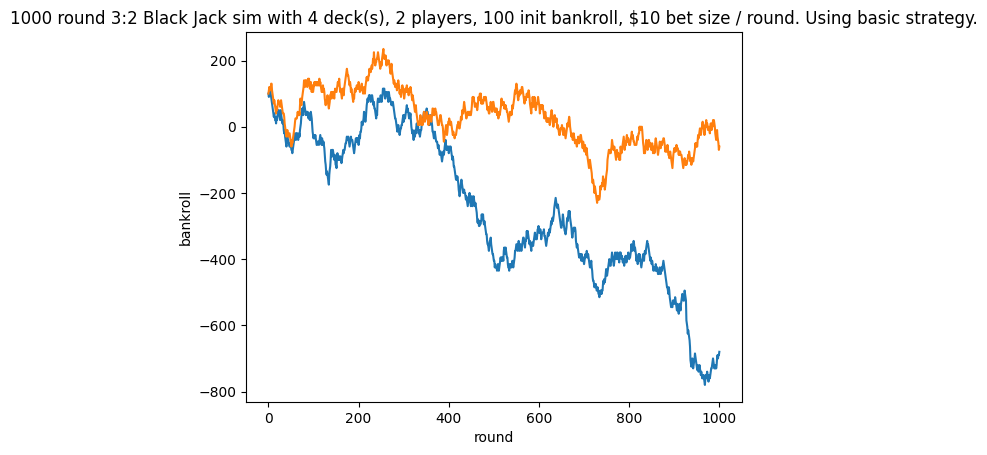

In [230]:
plot_historical_bankroll('basic', historical_bankroll, decks, number_of_rounds, number_of_players, bank_roll, bet_size, black_jack_type)